In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
import mb_xai.gut_interpret as gi
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import Lasso

DATA_LOC = '../../../Data/microbiome_xai/'
FLUX_DF_NAME_all_FILT = "micom_fluxes-top50-9285_samples_fd_VEGAN-2000.csv"

gut_data = gd.GutData() # required to load for renaming metabolites as their id 
gut_data.load_data( 
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/",
    FILE_FLUX_DF = "micom_medium-fluxes-top50-9285_samples_fd.csv"
)

Fixed EX_tDHNACOA(e)


,roc_auc,balanced_accuracy,average_precision,f1,f1_weighted
ibd_abundance,0.75±0.02,0.7±0.02,0.28±0.03,0.2±0.01,0.84±0.01
ibd_flux,0.67±0.03,0.63±0.03,0.14±0.03,0.15±0.01,0.8±0.02
ibs_abundance,0.58±0.02,0.56±0.01,0.19±0.01,0.26±0.01,0.62±0.01
ibs_flux,0.51±0.02,0.5±0.01,0.15±0.01,0.23±0.01,0.53±0.04
t2d_abundance,0.65±0.04,0.61±0.03,0.05±0.01,0.06±0.01,0.78±0.02
t2d_flux,0.5±0.04,0.51±0.04,0.02±0.0,0.04±0.01,0.72±0.03
vegan_abundance,0.73±0.04,0.68±0.03,0.07±0.02,0.1±0.01,0.83±0.01
vegan_flux,0.58±0.04,0.56±0.04,0.04±0.01,0.05±0.01,0.72±0.02


len(metab_overlap): 131
Non-zero feats (79,)
Non-zero feats (81,)
Non-zero feats (121,)
Non-zero feats (51,)


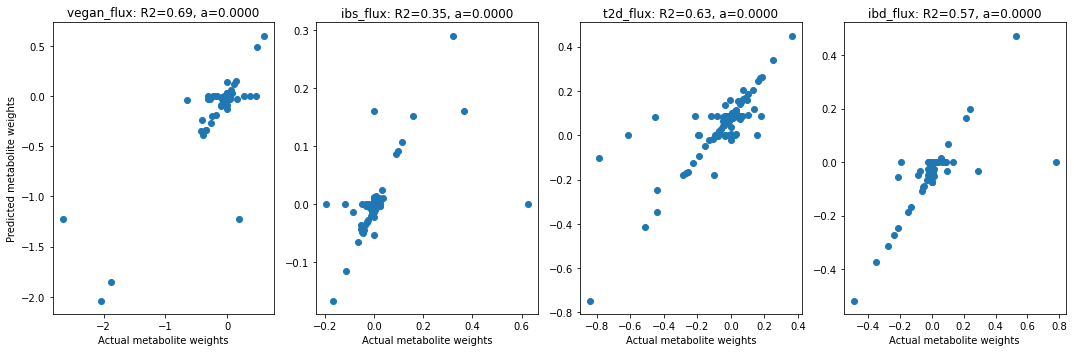

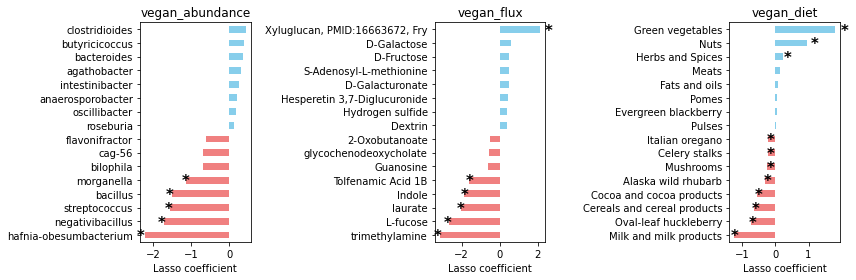

In [51]:
LASSO_ALPHA = 5#.5 #10e-(lasso_alpha) # 4 works well for PARALLEL_std-4_noparams_5_75

gut_interpret = gi.InterpretPred()
gut_interpret.load_pred(gut_data, 
    DIR_SIM_DATA=gut_data.dir_sim_data, 
    DATA_LOC=DATA_LOC,
    # SAVE_ID ="PARALLEL",
    SAVE_ID="PARALLEL_std-4_noparams_5_75",
    SAVE_FIG=True, 
    BOOL_FLUX_NOTMEDIUM=False)

gut_interpret.plot_performance_table(NO_DUMMY=True)
# gut_interpret.performance_table
display(gut_interpret.performance_table)

cols_foods = gut_interpret.food_matrix_df.columns[gut_interpret.food_matrix_df.sum()>3]
gut_interpret.food_matrix_df = gut_interpret.food_matrix_df[cols_foods]

gut_interpret.infer_foods(
    bool_concentrations=True, 
    bool_direct_flux=True, 
    bool_consumption=False, 
    normalize=True, 
    SAVE_ID_ALPHA=LASSO_ALPHA,
    PVAL_FILT=0.05)

ax = gut_interpret.plot_pheno_topfeats(pheno="vegan", n_feats=8, METAB_NAME=True, BOOL_DIRECT=True, PVAL_THRESH=0.05)

In [48]:
SIG_CUTOFF_METABS = 0.5
SIG_CUTOFF_FOODS = 0.05
# input_type = "flux_vegan"
input_type = "vegan_flux"

sig_foods = mb_utils.get_pvalues(gut_interpret.food_signal_df[input_type].sort_values(), sig_cutoff=SIG_CUTOFF_FOODS)
sig_foods = gut_interpret.food_signal_df[input_type].sort_values().loc[sig_foods.index]

sig_food_metabs = mb_utils.get_pvalues(gut_interpret.y_df[input_type].sort_values(), sig_cutoff=SIG_CUTOFF_METABS)
sig_food_metabs = gut_interpret.y_df[input_type].sort_values().loc[sig_food_metabs.index]
sig_food_metabs.name = input_type

df_sig_foods = pd.DataFrame()
for sig_food in sig_foods.index:
    # df_sig_foods = pd.concat([df_sig_foods, gut_interpret.A_df[sig_food].loc[sig_food_metabs.index]],axis=1)
    same_metabs = list(set(gut_interpret.A_df[sig_food][gut_interpret.A_df[sig_food]==1].index).intersection(set(sig_food_metabs.index)))
    df_add = sig_food_metabs.loc[same_metabs]
    df_add.name = sig_food
    df_sig_foods = pd.concat([df_sig_foods, df_add],axis=1)


df_sig_foods = df_sig_foods.loc[(df_sig_foods.sum(axis=1) != 0), (df_sig_foods.sum(axis=0) != 0)]
df_sig_foods[df_sig_foods==0]=np.nan
df_sig_foods

,Green vegetables,Milk and milk products,Nuts,Oval-leaf huckleberry,Cereals and cereal products,Cocoa and cocoa products,Alaska wild rhubarb,Mushrooms,Herbs and Spices,Celery stalks,Italian oregano
gsn[e],-0.645251,NaN,-0.645251,-0.645251,-0.645251,NaN,-0.645251,NaN,-0.645251,-0.645251,-0.645251
gly[e],-0.393305,NaN,-0.393305,-0.393305,-0.393305,NaN,-0.393305,NaN,-0.393305,-0.393305,-0.393305
ddca[e],-2.044167,NaN,-2.044167,-2.044167,-2.044167,NaN,-2.044167,NaN,-2.044167,-2.044167,-2.044167
indole[e],-1.885263,-1.885263,-1.885263,-1.885263,-1.885263,-1.885263,-1.885263,NaN,-1.885263,-1.885263,-1.885263
fuc_L[e],NaN,-2.660870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acnam[e],NaN,0.185421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tre[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.403494,NaN,NaN,NaN
fru[e],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.486696,NaN,NaN


In [6]:
gut_interpret.y_df["vegan_flux"].sort_values()

id
fuc_L[e]    -2.660870
ddca[e]     -2.044167
indole[e]   -1.885263
gsn[e]      -0.645251
arab_L[e]   -0.426121
               ...   
pheme[e]     0.263582
dad_2[e]     0.368012
galur[e]     0.465596
fru[e]       0.486696
gal[e]       0.596905
Name: vegan_flux, Length: 131, dtype: float64

In [10]:
gut_interpret.food_matrix_df.loc["fru[e]"].sort_values(ascending=False)

Honey                   39206.666667
Agave                   20460.000000
Date                    19706.666667
Molasses                12790.000000
Common grape            12603.666667
                            ...     
Yautia                           NaN
Yellow wax bean                  NaN
Yellowfin tuna                   NaN
Yellowtail amberjack             NaN
Zwieback                         NaN
Name: fru[e], Length: 882, dtype: float64

In [11]:
gut_interpret.food_matrix_df.loc["gal[e]"].sort_values(ascending=False)

Taro                    6465.000000
Milk (Cow)              2889.434441
Honey                   1550.000000
Dulce de leche          1030.000000
Snack bar                946.666667
                           ...     
Yellow wax bean                 NaN
Yellowfin tuna                  NaN
Yellowtail amberjack            NaN
Ymer                            NaN
Zwieback                        NaN
Name: gal[e], Length: 882, dtype: float64

In [19]:
from scipy.stats import hypergeom

def hypergeom_metab_foods(y_df, A_df, pheno_id, food_id, top_type="pos", n_top=20, verbose=True):
    top_neg_df = y_df[pheno_id].sort_values()[:n_top].copy()
    top_pos_df = y_df[pheno_id].sort_values()[-n_top:].copy()
    if top_type == "pos":
        metab_vector = top_pos_df
    elif top_type == "neg":
        metab_vector = top_neg_df

    # pvals_sig = mb_utils.get_pvalues(y_df[pheno_id], sig_cutoff=0.2)
    total_food_metabs = A_df.shape[1] # 931 (M)
    food_id_metabs = A_df[food_id][A_df[food_id]>0].shape[0] # - # of metabs in food id (n)
    # total_signal_metabs = pvals_sig.shape[0] # - # of metabs in metabolite signal vector (N)
    total_signal_metabs = metab_vector.shape[0]

    metab_grp = list(metab_vector.index)
    food_metab_grp = list(A_df[food_id][A_df[food_id]>0].index)
    signal_metabs_in_food = len(list(set(food_metab_grp).intersection(metab_grp))) # (K)
    if verbose==True:
        print("k:%s, M:%s, n:%s, N:%s"%(signal_metabs_in_food, total_food_metabs, food_id_metabs, total_signal_metabs))
    pval = hypergeom.sf(signal_metabs_in_food, total_food_metabs, food_id_metabs, total_signal_metabs)
    # print(food_id, pheno_id, pval)
    return pval

In [22]:
N_TOP = 10
top_type = "pos"
pheno_id = "vegan_flux"
pval = hypergeom_metab_foods(gut_interpret.y_df, gut_interpret.A_df, pheno_id, "Taro", 
                             top_type=top_type, n_top=N_TOP, verbose=True)
pval 

k:4, M:868, n:77, N:10


0.0008563398057858975

In [37]:
N_TOP = 40
pheno_id = "vegan_flux"
pos_food_pval_dict, neg_food_pval_dict = {}, {}
for top_type in ["pos", "neg"]:
    for food_id in gut_interpret.A_df.columns:
        pval = hypergeom_metab_foods(gut_interpret.y_df, gut_interpret.A_df, 
                                     pheno_id, food_id, top_type=top_type, n_top=N_TOP, verbose=False)
        if top_type == "pos":
            pos_food_pval_dict.update({food_id: pval})
        elif top_type == "neg":
            neg_food_pval_dict.update({food_id: pval})
            
pos_df = pd.Series(pos_food_pval_dict,name="pos")
neg_df = pd.Series(neg_food_pval_dict,name="neg")
hypergeom_food_df = pd.concat([pos_df, neg_df],axis=1)

In [38]:
hypergeom_food_df["pos"].sort_values()[:20]

Norway haddock       0.000000e+00
Red beetroot         2.021476e-22
Red bell pepper      4.259200e-22
Green bell pepper    4.259200e-22
Sweet orange         2.974139e-21
Green bean           8.834443e-21
Apple                1.257156e-20
Coconut              4.030180e-20
Sweet basil          4.030180e-20
Peach                4.030180e-20
Wild celery          5.780815e-20
Wheat                5.780815e-20
Date                 5.780815e-20
Spinach              8.248346e-20
Common bean          8.248346e-20
Carrot               9.470491e-20
Green zucchini       1.170903e-19
Wild leek            1.695874e-19
Milk (Cow)           3.252635e-19
Potato               3.252635e-19
Name: pos, dtype: float64

In [39]:
hypergeom_food_df["neg"].sort_values()[:20]

Soy cream                   0.000000e+00
Spotted seal                0.000000e+00
Atlantic menhaden           0.000000e+00
Norway haddock              0.000000e+00
Green bell pepper           3.209174e-25
Turnip                      1.128421e-24
Japanese pumpkin            1.711579e-24
Saskatoon berry             2.202952e-24
Orange bell pepper          2.580179e-24
Yellow bell pepper          2.580179e-24
Carrot                      3.261776e-24
Cucumber                    5.760228e-24
Garden onion                5.760228e-24
Potato                      1.257225e-23
Red bell pepper             1.257225e-23
Broccoli                    1.842402e-23
Italian sweet red pepper    1.890043e-23
Dill                        2.847632e-23
Nanking cherry              3.497042e-23
Parsnip                     4.263862e-23
Name: neg, dtype: float64

In [27]:
hypergeom_food_df["neg"].sort_values()[:20]

Norway haddock              0.000000e+00
Soy cream                   0.000000e+00
Turnip                      2.371151e-07
Garden tomato               2.608481e-07
Japanese pumpkin            2.608481e-07
Flaxseed                    2.608481e-07
Cucumber                    3.448618e-07
Garden onion                3.448618e-07
Milk (Cow)                  4.131203e-07
Potato                      4.131203e-07
Green bell pepper           4.131203e-07
Broccoli                    4.514433e-07
Carrot                      6.930198e-07
Saskatoon berry             3.522680e-06
Bitter gourd                4.208064e-06
Dripping                    4.392299e-06
Common mushroom             4.590998e-06
Shiitake                    4.590998e-06
Romaine lettuce             5.002991e-06
Italian sweet red pepper    5.445812e-06
Name: neg, dtype: float64

{'gsn[e]': 'grey', 'gly[e]': 'grey', 'ddca[e]': 'grey', 'acnam[e]': 'grey', 'indole[e]': 'grey', 'fuc_L[e]': 'grey', 'Cocoa and cocoa products': 'grey', 'Cereals and cereal products': 'grey', 'Green vegetables': 'grey', 'Nuts': 'grey', 'Milk and milk products': 'grey', 'Alaska wild rhubarb': 'grey'}


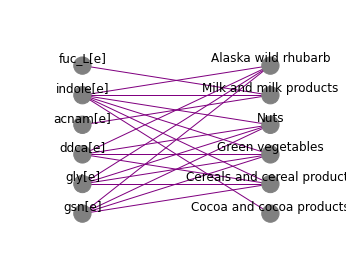

In [11]:
SAVE_ID = "networkx_TESTfood"
gi.plot_nx_genera_flux(
    gut_data,SAVE_ID, df_sig_foods, 
    gut_interpret.flux_pheno_direct_df_metab, 
    gut_interpret.imp_feat_abundance_pheno_df, pheno="vegan", cutoff_val=0.2, SAVE_FIG=False)

In [71]:
gut_interpret.food_matrix_df["Meats"].fillna(0).sort_values()[-15:]

source_id
4hpro_LT[e]    0.0
3hphac[e]      0.0
fe3[e]         0.0
ncam[e]        0.0
arbt[e]        0.0
btn[e]         1.0
bz[e]          1.0
chol[e]        1.0
pcresol[e]     1.0
succ[e]        1.0
spmd[e]        1.0
alahis[e]      1.0
thm[e]         1.0
ins[e]         1.0
sprm[e]        1.0
Name: Meats, dtype: float64

In [42]:
gut_interpret.A_df["Milk and milk products"].sort_values()

source_id
ncam[e]       0.0
nac[e]        0.0
ptrc[e]       0.0
asp_L[e]      0.0
Lcystin[e]    0.0
             ... 
indole[e]     1.0
acnam[e]      1.0
succ[e]       1.0
chol[e]       1.0
fuc_L[e]      1.0
Name: Milk and milk products, Length: 131, dtype: float64

In [38]:
gut_interpret.A_df["Crustaceans"].sort_values()

source_id
ncam[e]      0.0
pnto_R[e]    0.0
nac[e]       0.0
ptrc[e]      0.0
asp_L[e]     0.0
            ... 
ribflv[e]    0.0
cgly[e]      0.0
chol[e]      0.0
gua[e]       0.0
indole[e]    1.0
Name: Crustaceans, Length: 131, dtype: float64

In [24]:
SIG_CUTOFF_METABS = 0.2
SIG_CUTOFF_FOODS = 0.05
# input_type = "flux_vegan"
input_type = "vegan_flux"

sig_food_metabs = mb_utils.get_pvalues(gut_interpret.y_df[input_type].sort_values(), sig_cutoff=SIG_CUTOFF_METABS)
sig_food_metabs = gut_interpret.y_df[input_type].sort_values().loc[sig_food_metabs.index]
sig_food_metabs.name = input_type

df_sig_foods = pd.DataFrame()
for sig_food_metab in sig_food_metabs.index:
    sig_foods = mb_utils.get_pvalues(gut_interpret.A_df.loc[sig_food_metab], sig_cutoff=SIG_CUTOFF_FOODS)
    sig_foods.name = sig_food_metab
    df_sig_foods = pd.concat([df_sig_foods, sig_foods],axis=1)
df_sig_foods

,fuc_L[e],ddca[e],indole[e],gal[e],gsn[e],fru[e],galur[e]
Milk (Cow),3.370022e-202,NaN,NaN,1.207043e-31,NaN,NaN,NaN
Babassu palm,NaN,3.411418e-100,NaN,NaN,NaN,NaN,NaN
Oil palm,NaN,3.847137e-59,NaN,NaN,NaN,NaN,NaN
Coconut,NaN,1.727670e-32,NaN,NaN,NaN,NaN,1.505841e-10
Ucuhuba,NaN,1.396862e-07,NaN,NaN,NaN,NaN,NaN
Sour cream,NaN,9.689622e-05,NaN,NaN,NaN,NaN,NaN
Coffee mocha,NaN,7.181535e-03,NaN,NaN,NaN,NaN,NaN
Taro,NaN,NaN,NaN,2.440463e-152,NaN,NaN,NaN
Honey,NaN,NaN,NaN,4.361692e-10,NaN,4.584889e-82,NaN
Dulce de leche,NaN,NaN,NaN,3.801834e-05,NaN,NaN,NaN


In [5]:
pvals=mb_utils.get_pvalues(gut_interpret.y_df["vegan_flux"])
gut_interpret.y_df["vegan_flux"].loc[pvals.index]

id
fuc_L[e]    -2.660870
ddca[e]     -2.044167
indole[e]   -1.885263
Name: vegan_flux, dtype: float64

In [13]:
gut_interpret.food_matrix_df.fillna(0).sum(axis=1).sort_values()

source_id
estroneglc[e]      2.650500e-05
estradiolglc[e]    3.926667e-04
cbl1[e]            2.860000e-03
gcald[e]           1.000000e+00
glyleu[e]          1.000000e+00
                       ...     
glu_L[e]           9.650995e+05
lnlc[e]            1.198125e+06
ocdcea[e]          1.268226e+06
sucr[e]            1.543921e+06
chsterol[e]        2.782244e+06
Length: 217, dtype: float64

In [5]:
gut_interpret.food_signal_df["vegan_flux"].sort_values()

Crustaceans                -1.183073
Milk and milk products     -1.028066
Half-highbush blueberry    -0.336815
Mushrooms                  -0.167850
European cranberry         -0.164969
                              ...   
Norway pout                 0.206866
Beverages                   0.238537
Meats                       0.257957
Cocoa and cocoa products    0.387078
Green vegetables            0.653732
Name: vegan_flux, Length: 931, dtype: float64

In [6]:
pvals=mb_utils.get_pvalues(gut_interpret.flux_pheno_direct_df_metab["vegan_flux"])

In [7]:
gut_interpret.flux_pheno_direct_df_metab["vegan_flux"].loc[pvals.index]

trimethylamine                   -3.159414
L-fucose                         -2.660870
Xyluglucan, PMID:16663672, Fry    2.132906
laurate                          -2.044167
Indole                           -1.885263
Tolfenamic Acid 1B               -1.615845
Name: vegan_flux, dtype: float64

In [17]:
gut_interpret.flux_pheno_direct_df_metab

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
"1,2-Diacyl-sn-glycerol (diocta",0.089747,-0.089560,0.042311,-0.025330
"meso-2,6-Diaminoheptanedioate",-0.065124,NaN,0.008713,-0.024152
2-Dehydro-3-deoxy-D-gluconate,-0.046554,NaN,0.011553,NaN
2-Demethylmenaquinone 8,-0.054496,NaN,0.165349,NaN
2-Oxobutanoate,-0.509887,-0.002244,0.001557,NaN
...,...,...,...,...
Spermidine,NaN,NaN,0.010289,NaN
starch n=1200 repeat units (30,NaN,NaN,-0.009499,NaN
Stachyose,NaN,NaN,-0.003023,NaN
thiosulfate(2-),NaN,NaN,-0.030407,NaN


,roc_auc,balanced_accuracy,average_precision,f1,f1_weighted
ibd_abundance,0.75±0.02,0.7±0.02,0.28±0.03,0.2±0.01,0.84±0.01
ibd_flux,0.67±0.03,0.63±0.03,0.14±0.03,0.15±0.01,0.8±0.02
ibs_abundance,0.58±0.02,0.56±0.01,0.19±0.01,0.26±0.01,0.62±0.01
ibs_flux,0.51±0.02,0.5±0.01,0.15±0.01,0.23±0.01,0.53±0.04
t2d_abundance,0.65±0.04,0.61±0.03,0.05±0.01,0.06±0.01,0.78±0.02
t2d_flux,0.5±0.04,0.51±0.04,0.02±0.0,0.04±0.01,0.72±0.03
vegan_abundance,0.73±0.04,0.68±0.03,0.07±0.02,0.1±0.01,0.83±0.01
vegan_flux,0.58±0.04,0.56±0.04,0.04±0.01,0.05±0.01,0.72±0.02


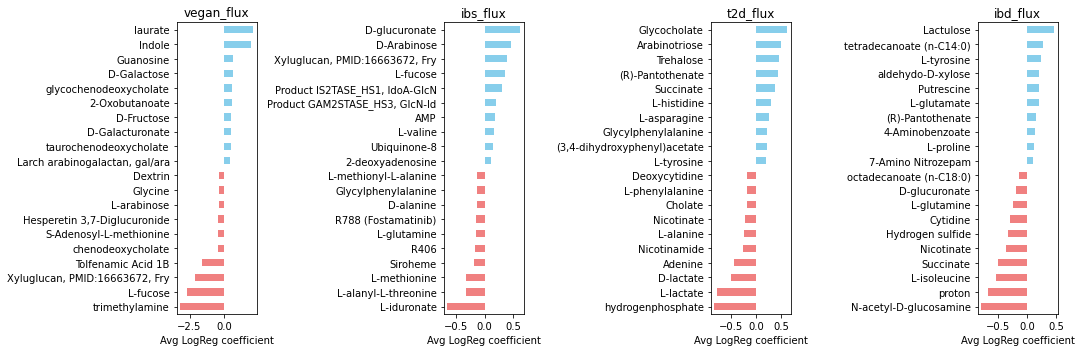

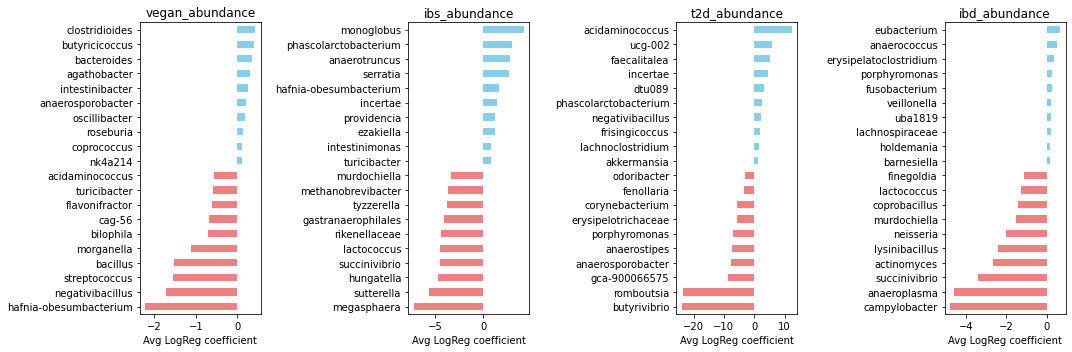

In [5]:
gut_interpret = gi.InterpretPred()
gut_interpret.load_pred(gut_data, 
    DIR_SIM_DATA=gut_data.dir_sim_data, 
    DATA_LOC=DATA_LOC,
    # SAVE_ID ="PARALLEL"
    SAVE_ID="PARALLEL_std-4_noparams_5_75",
    SAVE_FIG=True, 
    BOOL_FLUX_NOTMEDIUM=False)

gut_interpret.plot_performance_table(NO_DUMMY=True)
# gut_interpret.performance_table
display(gut_interpret.performance_table)
gut_interpret.plot_flux_genera_topfeats(n_feats=10, METAB_NAME=True)

len(metab_overlap): 131
Non-zero feats (79,)
Non-zero feats (81,)
Non-zero feats (121,)
Non-zero feats (51,)


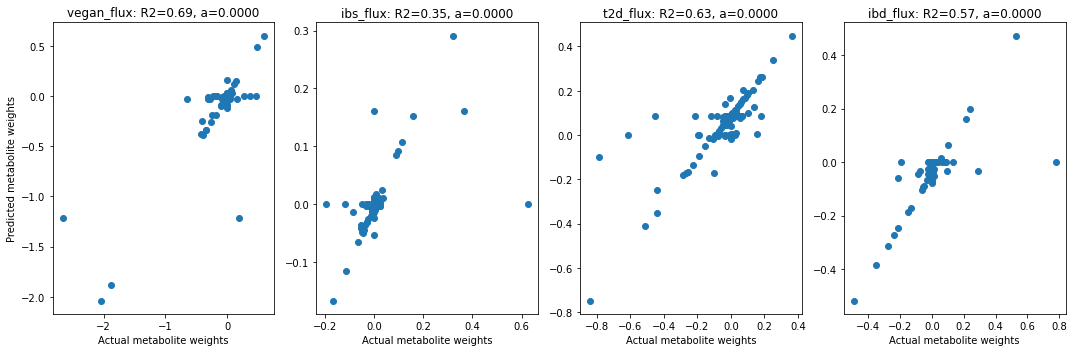

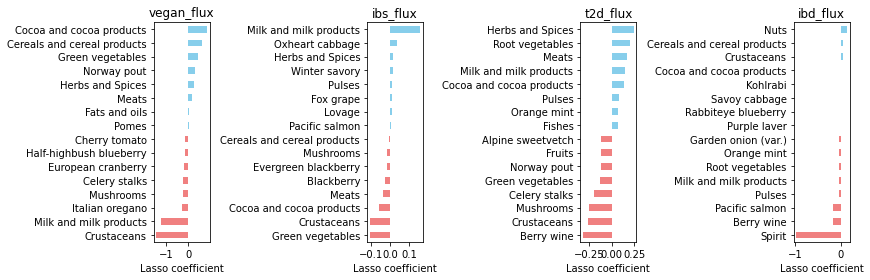

In [7]:
gut_interpret.infer_foods(
    bool_concentrations=True, 
    bool_direct_flux=True, 
    bool_consumption=False, 
    normalize=True, 
    SAVE_ID_ALPHA=5)

gut_interpret.plot_food_topfeats(n_feats=8)

len(metab_overlap): 131
Non-zero feats (79,)
Non-zero feats (81,)
Non-zero feats (121,)
Non-zero feats (51,)


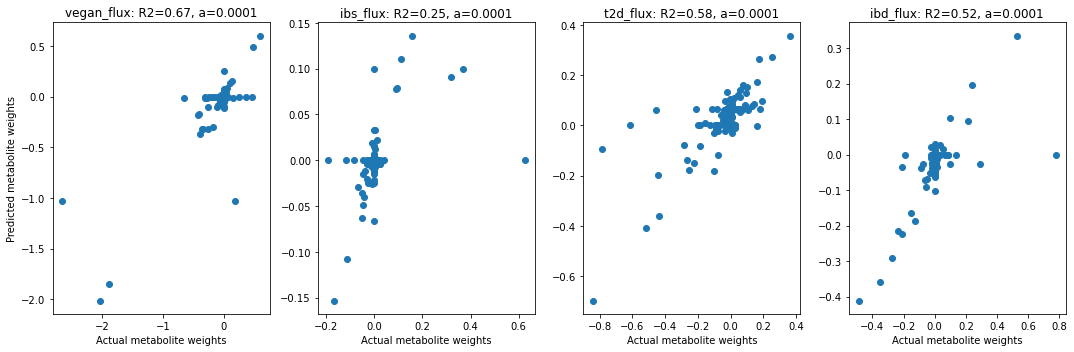

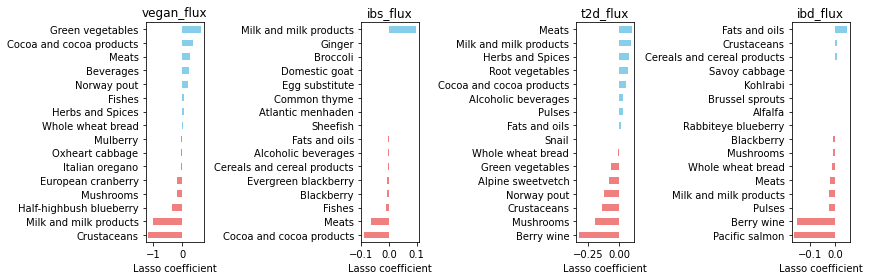

In [16]:
gut_interpret.infer_foods(
    bool_concentrations=True, 
    bool_direct_flux=True, 
    bool_consumption=False, 
    normalize=True, 
    SAVE_ID_ALPHA=4)

gut_interpret.plot_food_topfeats(n_feats=8)

len(metab_overlap): 90
Non-zero feats (54,)
Non-zero feats (57,)
Non-zero feats (83,)
Non-zero feats (36,)


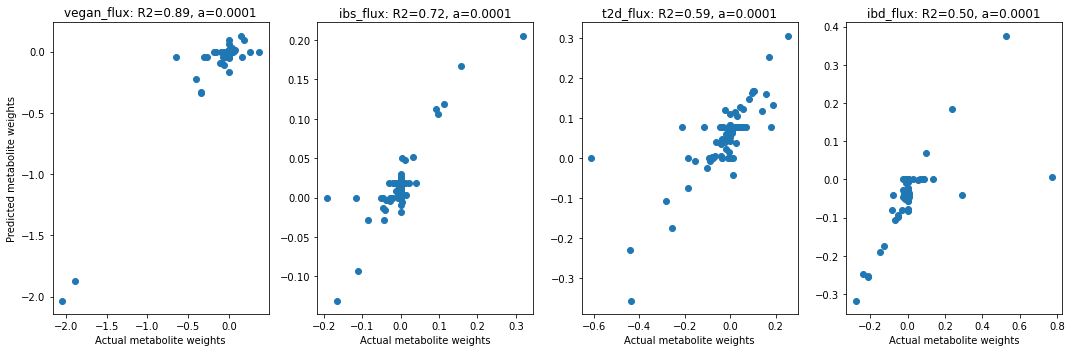

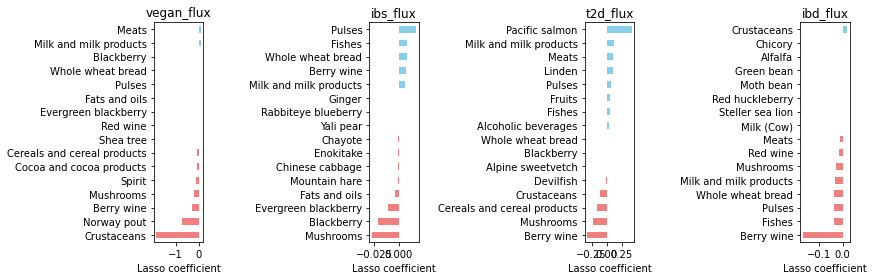

In [15]:
gut_interpret.infer_foods(
    bool_concentrations=True, 
    bool_direct_flux=True, 
    bool_consumption=True, 
    normalize=True, 
    SAVE_ID_ALPHA=4)

gut_interpret.plot_food_topfeats(n_feats=8)

In [23]:
list("321")

['3', '2', '1']

In [27]:
l1 = [1, 2, 3]
l1[:-1]

[1]

In [21]:
l1 = [1, 2, 3] #[::-1]
l1 = l1[::-1]
l1_str = [str(x) for x in l1]
ls_int = int("".join(l1_str))
ls_int

321

In [4]:
gut_interpret.SAVE_ID_ALPHA

4

In [5]:
gut_interpret.SAVE_ID

'PARALLEL_std-4_noparams_5_75'

In [6]:
gut_interpret.bool_concentrations

True

In [7]:
gut_interpret.bool_direct_flux

True

In [9]:
gut_interpret.dir_sim_data